<a href="https://colab.research.google.com/github/AlumiK/tensorflow2-notebooks/blob/main/05%20Natural%20Language%20Processing/13_lstm_spam_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Spam Detection

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ae52d554-9816-f5f7-9815-af9acbf9f895)


In [ ]:
!wget -nc 'https://lazyprogrammer.me/course_files/spam.csv'

df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df.head()

X = df['v2'].values
y = df['v1'].map({'ham': 0, 'spam': 1}).values
X_train_texts, X_test_texts, y_train, y_test = train_test_split(X, y, test_size=0.33)

MAX_VOCAB_SIZE = 20000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_train_texts)
X_train = tokenizer.texts_to_sequences(X_train_texts)
X_test = tokenizer.texts_to_sequences(X_test_texts)

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train)
T = X_train.shape[1]
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=T)

V = len(tokenizer.word_index)
D = 20
M = 15

--2020-10-09 02:45:01--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.31.81.48, 104.31.80.48, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K   608KB/s    in 0.8s    

2020-10-09 02:45:03 (608 KB/s) - ‘spam.csv’ saved [503663/503663]



Epoch 1/10
117/117 [==============================] - 2s 17ms/step - loss: 0.4510 - accuracy: 0.8669 - val_loss: 0.3900 - val_accuracy: 0.8641
Epoch 2/10
117/117 [==============================] - 2s 13ms/step - loss: 0.3175 - accuracy: 0.8669 - val_loss: 0.2331 - val_accuracy: 0.8641
Epoch 3/10
117/117 [==============================] - 2s 14ms/step - loss: 0.1869 - accuracy: 0.9095 - val_loss: 0.1689 - val_accuracy: 0.9701
Epoch 4/10
117/117 [==============================] - 2s 14ms/step - loss: 0.1149 - accuracy: 0.9887 - val_loss: 0.1209 - val_accuracy: 0.9793
Epoch 5/10
117/117 [==============================] - 2s 13ms/step - loss: 0.0729 - accuracy: 0.9936 - val_loss: 0.0950 - val_accuracy: 0.9761
Epoch 6/10
117/117 [==============================] - 2s 13ms/step - loss: 0.0496 - accuracy: 0.9946 - val_loss: 0.0831 - val_accuracy: 0.9766
Epoch 7/10
117/117 [==============================] - 2s 13ms/step - loss: 0.0352 - accuracy: 0.9968 - val_loss: 0.0752 - val_accuracy: 0.9782

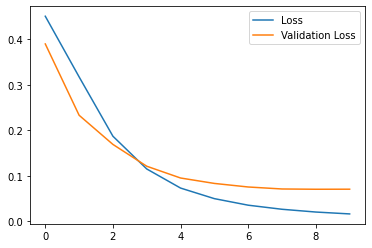

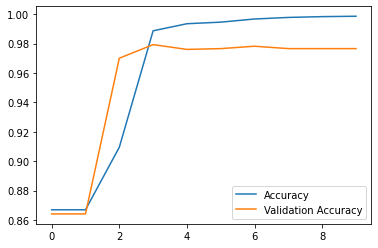

58/58 [==============================] - 0s 5ms/step - loss: 0.0704 - accuracy: 0.9766
Accuracy: 0.9766177535057068


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(T,)),
    tf.keras.layers.Embedding(V + 1, D),
    tf.keras.layers.LSTM(M, return_sequences=True),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(1, activation='sigmoid'),   
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

r = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

plt.plot(r.history.get('loss'), label='Loss')
plt.plot(r.history.get('val_loss'), label='Validation Loss')
plt.legend()
plt.show()

plt.plot(r.history.get('accuracy'), label='Accuracy')
plt.plot(r.history.get('val_accuracy'), label='Validation Accuracy')
plt.legend()
plt.show()

print(f'Accuracy: {model.evaluate(X_test, y_test)[1]}')

## Display a misclassified sentence

In [ ]:
labels = ['Ham', 'Spam']
p_test = np.rint(model.predict(X_test).flatten()).astype(np.int)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
print(f'Sentence: {X_test_texts[i]}')
print(f'Truth: {labels[y_test[i]]}\nPredicted: {labels[p_test[i]]}')

Sentence: Sorry I missed your call let's talk when you have the time. I'm on 07090201529
Truth: Spam
Predicted: Ham


## Predict a custom sentence

In [ ]:
custom_text = 'I will give you a big gift at your birthday party!'
p_test = np.rint(
    model.predict(
        tf.keras.preprocessing.sequence.pad_sequences(
            tokenizer.texts_to_sequences([custom_text]),
            maxlen=T
        )
    ).flatten()
).astype(np.int)
print(f'Prediction: {labels[p_test[0]]}')

Prediction: Ham
